<a href="https://colab.research.google.com/github/siriusted/gym-dssat-notebooks/blob/master/Package_installation_on_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!echo "deb [ arch=amd64 ] https://raw.githubusercontent.com/pdidev/repo/ubuntu bionic main" | sudo tee /etc/apt/sources.list.d/pdi.list > /dev/null
!wget -O /etc/apt/trusted.gpg.d/pdidev-archive-keyring.gpg https://raw.githubusercontent.com/pdidev/repo/ubuntu/pdidev-archive-keyring.gpg
!chmod a+r /etc/apt/trusted.gpg.d/pdidev-archive-keyring.gpg /etc/apt/sources.list.d/pdi.list
!apt update &> /dev/null
!apt install pdidev-archive-keyring libpdi-dev &> /dev/null

--2022-03-10 16:14:39--  https://raw.githubusercontent.com/pdidev/repo/ubuntu/pdidev-archive-keyring.gpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1753 (1.7K) [application/octet-stream]
Saving to: ‘/etc/apt/trusted.gpg.d/pdidev-archive-keyring.gpg’

/etc/apt/trusted.gp 100%[===================>]   1.71K  --.-KB/s    in 0s      

2022-03-10 16:14:39 (19.1 MB/s) - ‘/etc/apt/trusted.gpg.d/pdidev-archive-keyring.gpg’ saved [1753/1753]



In [ ]:
!wget  http://gac.udc.es/~emilioj/bionic.tgz
!tar -xf bionic.tgz
!cd bionic/ && apt install `find . -name "*.deb"` &> /dev/null

In [9]:
!pip install stable-baselines3 &> /dev/null
!pip install -U PyYAML &> /dev/null

     |████████████████████████████████| 596 kB 8.8 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [5]:
import os

os.environ["PATH"] = "/opt/gym_dssat_pdi/bin:" + os.environ["PATH"]
os.environ["PYTHONPATH"] = "/opt/gym_dssat_pdi/lib/python3.7/site-packages/:" + os.environ["PYTHONPATH"]
# os.environ["GYM_DSSAT_PDI_PATH"] = "/opt/gym_dssat_pdi/lib/python3.6/site-packages/gym_dssat_pdi"

In [3]:
!python --version

Python 3.7.12


In [1]:
import sys

sys.path.append('/opt/gym_dssat_pdi/lib/python3.7/site-packages')

In [2]:
import gym
import gym_dssat_pdi
import torch
import numpy as np

In [4]:
env_args = {
            'run_dssat_location': '/opt/dssat_pdi/run_dssat',
            'mode': 'fertilization',
            'seed': 123456,
            'random_weather': True,
        }

env = gym.make('gym_dssat_pdi:GymDssatPdi-v0', **env_args)

In [5]:
env.observation

{'dap': 4377089,
 'dtt': 0.0,
 'grnwt': 0.0,
 'istage': 7,
 'nstres': 0.0,
 'pltpop': 7.199999809265137,
 'rain': 0.10000000149011612,
 'rtdep': 0.0,
 'srad': 8.652971267700195,
 'swfac': 0.0,
 'tmax': 18.56235122680664,
 'tmin': 6.544256687164307,
 'topwt': 0.0,
 'totaml': 0.0,
 'vstage': 0.0,
 'xlai': 0.0}

In [6]:
env.close()

In [7]:
# helpers for action normalization
def normalize_action(action_space_limits, action):
    """Normalize the action from [low, high] to [-1, 1]"""
    low, high = action_space_limits
    return 2.0 * ((action - low) / (high - low)) - 1.0

def denormalize_action(action_space_limits, action):
    """Denormalize the action from [-1, 1] to [low, high]"""
    low, high = action_space_limits
    return low + (0.5 * (action + 1.0) * (high - low))

# Wrapper for easy and uniform interfacing with SB3
class GymDssatWrapper(gym.Wrapper):
    def __init__(self, env):
        super(GymDssatWrapper, self).__init__(env)

        self.action_low, self.action_high = self._get_action_space_bounds()

        # using a normalized action space
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(1,), dtype="float32")

        # using a vector representation of observations to allow
        # easily using SB3 MlpPolicy
        self.observation_space = gym.spaces.Box(low=0.0,
                                                high=np.inf,
                                                shape=env.observation_dict_to_array(
                                                    env.observation).shape,
                                                dtype="float32"
                                                )

        # to avoid annoying problem with Monitor when episodes end and things are None
        self.last_info = {}
        self.last_obs = None

    def _get_action_space_bounds(self):
        box = self.env.action_space['anfer']
        return box.low, box.high

    def _format_action(self, action):
        return { 'anfer': action[0] }

    def _format_observation(self, observation):
        return self.env.observation_dict_to_array(observation)

    def reset(self):
        return self._format_observation(self.env.reset())


    def step(self, action):
        # Rescale action from [-1, 1] to original action space interval
        denormalized_action = denormalize_action((self.action_low, self.action_high), action)
        formatted_action = self._format_action(denormalized_action)
        obs, reward, done, info = self.env.step(formatted_action)

        # handle `None`s in obs, reward, and info on done step
        if done:
            obs, reward, info = self.last_obs, 0, self.last_info
        else:
            self.last_obs = obs
            self.last_info = info

        formatted_observation = self._format_observation(obs)
        return formatted_observation, reward, done, info

    def close(self):
        return self.env.close()

    def eval(self):
        self.env.set_evaluation()

    def __del__(self):
        self.close()

In [8]:
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor

# Create environment
env_args = {
    'run_dssat_location': '/opt/dssat_pdi/run_dssat',
    'mode': 'fertilization',
    'seed': 123,
    'random_weather': True,
}

env = Monitor(GymDssatWrapper(gym.make('GymDssatPdi-v0', **env_args)))

In [9]:
# Training arguments for PPO agent
ppo_args = {
    'seed': 123, # seed training for reproducibility
}

# Create the agent
ppo_agent = PPO('MlpPolicy', env, **ppo_args)

# Train for 10k timesteps
print('Training PPO agent...')
ppo_agent.learn(total_timesteps=40_000)
print('Training done')

Training PPO agent...
Training done


In [10]:
# Baseline agents for comparison
class NullAgent:
    """
    Agent always choosing to do no fertilization
    """
    def __init__(self, env):
        self.env = env

    def predict(self, obs, state=None, episode_start=None, deterministic=None):
        action = normalize_action((self.env.action_low, self.env.action_high), [0])
        return np.array([action], dtype=np.float32), obs


class ExpertAgent:
    """
    Simple agent using policy of choosing fertilization amount based on days after planting
    """
    fertilization_dic = {
        40: 27,
        45: 35,
        80: 54,
    }

    def __init__(self, env, normalize_action=False, fertilization_dic=None):
        self.env = env
        self.normalize_action = normalize_action

    def _policy(self, obs):
        dap = int(obs[0][0])
        return [self.fertilization_dic[dap] if dap in self.fertilization_dic else 0]

    def predict(self, obs, state=None, episode_start=None, deterministic=None):
        action = self._policy(obs)
        action = normalize_action((self.env.action_low, self.env.action_high), action)

        return np.array([action], dtype=np.float32), obs

In [11]:
from stable_baselines3.common.evaluation import evaluate_policy

#evaluation and plotting functions
def evaluate(agent, n_episodes=10):
    # Create eval env
    eval_args = {
        'run_dssat_location': '/opt/dssat_pdi/run_dssat',
        'mode': 'fertilization',
        'seed': 456,
        'random_weather': True,
    }
    env = Monitor(GymDssatWrapper(gym.make('GymDssatPdi-v0', **eval_args)))

    env.eval()

    returns, _ = evaluate_policy(
        agent, env, n_eval_episodes=n_episodes, return_episode_rewards=True)
    
    env.close()

    return returns

# evaluate agents
null_agent = NullAgent(env)
print('Evaluating Null agent...')
null_returns = evaluate(null_agent)
print('Done')
print('Evaluating PPO agent...')
ppo_returns = evaluate(ppo_agent)
print('Done')

expert_agent = ExpertAgent(env)
print('Evaluating Expert agent...')
expert_returns = evaluate(expert_agent)
print('Done')

# write results to a file to be loaded for display
data = [('null', null_returns), ('ppo', ppo_returns), ('expert', expert_returns)]

Evaluating Null agent...
Done
Evaluating PPO agent...
Done
Evaluating Expert agent...
Done


In [ ]:
print(data)

In [12]:
import pickle
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def plot_results(data):
    data_dict = {}
    for label, returns in data:
        data_dict[label] = returns
    df = pd.DataFrame(data_dict)
    
    ax = sns.boxplot(data=df)
    ax.set_xlabel("policy")
    ax.set_ylabel("evaluation output")
    plt.show()

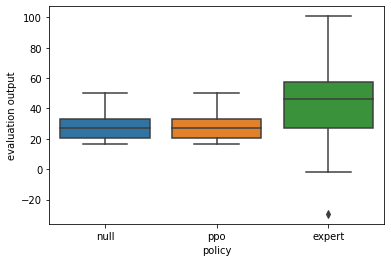

In [13]:
plot_results(data)

## Bonus: Saving best performing model

In this section, we will use a feature from stable-baselines3 known as `callbacks`. They enable different kind of operations during the training of a model. For our purpose here, we will use the `EvalCallback` to periodically evaluate and save the best performing model we find during training.

For more on callbacks in stable-baselines3 see [here](https://stable-baselines3.readthedocs.io/en/master/guide/callbacks.html)

In [14]:
from stable_baselines3.common.callbacks import EvalCallback

env = Monitor(GymDssatWrapper(gym.make('GymDssatPdi-v0', **env_args)))


# Create the agent
ppo_agent = PPO('MlpPolicy', env, **ppo_args)

# path to save best model found
path = 'ppo'

# eval callback
eval_freq = 1000
eval_env_args = {**env_args, 'seed': 345}
eval_env = Monitor(GymDssatWrapper(gym.make('GymDssatPdi-v0', **eval_env_args)))
eval_callback = EvalCallback(eval_env,
                                eval_freq=eval_freq,
                                best_model_save_path=f'./{path}',
                                deterministic=True)


# Train
print('Training PPO agent...')
ppo_agent.learn(total_timesteps=50_000, callback=eval_callback)
ppo_agent.save(f'./{path}/final_model')
print('Training done')

Training PPO agent...
Eval num_timesteps=1000, episode_reward=-8572.75 +/- 2094.55
Episode length: 153.40 +/- 2.42
New best mean reward!
Eval num_timesteps=2000, episode_reward=-8757.15 +/- 1849.20
Episode length: 156.60 +/- 2.33
Eval num_timesteps=3000, episode_reward=-7420.59 +/- 1541.66
Episode length: 156.20 +/- 1.47
New best mean reward!
Eval num_timesteps=4000, episode_reward=-7275.33 +/- 1375.06
Episode length: 158.20 +/- 1.47
New best mean reward!
Eval num_timesteps=5000, episode_reward=-5932.76 +/- 1409.70
Episode length: 156.00 +/- 6.42
New best mean reward!
Eval num_timesteps=6000, episode_reward=-5485.42 +/- 385.85
Episode length: 158.40 +/- 2.65
New best mean reward!
Eval num_timesteps=7000, episode_reward=-5259.26 +/- 1081.93
Episode length: 156.60 +/- 1.62
New best mean reward!
Eval num_timesteps=8000, episode_reward=-5101.42 +/- 1905.51
Episode length: 154.40 +/- 4.72
New best mean reward!
Eval num_timesteps=9000, episode_reward=-3558.30 +/- 581.78
Episode length: 155.2

In [15]:
# evaluate agents
null_agent = NullAgent(env)
print('Evaluating Null agent...')
null_returns = evaluate(null_agent)
print('Done')

print('Evaluating PPO agents...')
ppo_best = PPO.load(f'./{path}/best_model')
ppo_best_returns = evaluate(ppo_best)
ppo_returns = evaluate(ppo_agent)
print('Done')

expert_agent = ExpertAgent(env)
print('Evaluating Expert agent...')
expert_returns = evaluate(expert_agent)
print('Done')

# write results to a file to be loaded for display
results = [('null', null_returns), ('ppo(best)', ppo_best_returns),  ('ppo(final)', ppo_returns), ('expert', expert_returns)]

Evaluating Null agent...
Done
Evaluating PPO agents...
Done
Evaluating Expert agent...
Done


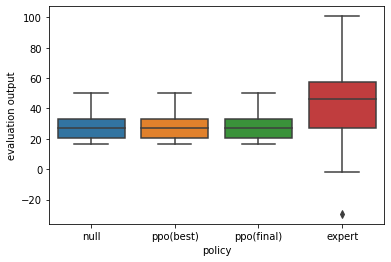

In [16]:
plot_results(results)